In [1]:
%pip install torch torchvision --index-url https://download.pytorch.org/whl/cu128
%pip install matplotlib

Looking in indexes: https://download.pytorch.org/whl/cu128
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch
import torch.nn as nn
import torchvision.models as models
import matplotlib.pyplot as plt
import numpy as np
import torchvision

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:

from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

torch.manual_seed(42)

transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

dataset = datasets.ImageFolder('./colored_images', transform=transform)

class_names = dataset.classes
print(f"Labels: {class_names}")

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, num_workers=24, pin_memory=True, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, num_workers=24, pin_memory=True, shuffle=False)

Labels: ['Mild', 'Moderate', 'No_DR', 'Proliferate_DR', 'Severe']


In [5]:
efficientnet = models.efficientnet_b0(pretrained=True)

for param in efficientnet.parameters():
    param.requires_grad = False

feature_extractor = nn.Sequential(
    efficientnet.features,
    nn.AdaptiveAvgPool2d((7, 7))
)

/home/john/Developer/diabetic-retinopathy/.conda/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/john/Developer/diabetic-retinopathy/.conda/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
class EfficientNetLSTMClassifier(nn.Module):
    def __init__(self, lstm_hidden_size=128, num_classes=5):
        super().__init__()
        self.features = feature_extractor
        self.lstm = nn.LSTM(input_size=49, hidden_size=lstm_hidden_size, num_layers=2, batch_first=True)
        self.fc = nn.Linear(lstm_hidden_size, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 1280, -1)
        lstm_out, _ = self.lstm(x)
        out = lstm_out[:, -1, :]
        
        return self.fc(out)


In [7]:
model = EfficientNetLSTMClassifier(num_classes=5).to(device=device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [8]:
correct = 0
total = 0

for epoch in range(300):
    total_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        out = model(images)
        loss = criterion(out, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(out, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f"Epoch [{epoch+1}/300], Loss: {total_loss/len(train_loader):.4f}, Accuracy: {accuracy:.2f}%")

Epoch [1/300], Loss: 1.1495, Accuracy: 57.35%
Epoch [2/300], Loss: 1.0126, Accuracy: 60.70%
Epoch [3/300], Loss: 0.9647, Accuracy: 62.16%
Epoch [4/300], Loss: 0.9142, Accuracy: 63.33%
Epoch [5/300], Loss: 0.8871, Accuracy: 64.23%
Epoch [6/300], Loss: 0.8711, Accuracy: 64.93%
Epoch [7/300], Loss: 0.8545, Accuracy: 65.47%
Epoch [8/300], Loss: 0.8332, Accuracy: 66.01%
Epoch [9/300], Loss: 0.8266, Accuracy: 66.42%
Epoch [10/300], Loss: 0.8132, Accuracy: 66.82%
Epoch [11/300], Loss: 0.7993, Accuracy: 67.15%
Epoch [12/300], Loss: 0.7918, Accuracy: 67.44%
Epoch [13/300], Loss: 0.7612, Accuracy: 67.72%
Epoch [14/300], Loss: 0.7674, Accuracy: 67.97%
Epoch [15/300], Loss: 0.7548, Accuracy: 68.21%
Epoch [16/300], Loss: 0.7339, Accuracy: 68.49%
Epoch [17/300], Loss: 0.7094, Accuracy: 68.74%
Epoch [18/300], Loss: 0.6923, Accuracy: 69.03%
Epoch [19/300], Loss: 0.7041, Accuracy: 69.30%
Epoch [20/300], Loss: 0.6657, Accuracy: 69.60%
Epoch [21/300], Loss: 0.6577, Accuracy: 69.85%
Epoch [22/300], Loss: 

In [9]:
torch.save(model.state_dict(), "EfficientNetB0_no_grad_lstm.pt")

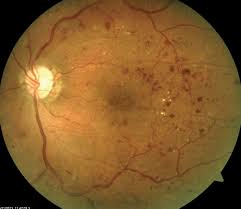

Image: /home/john/Developer/diabetic-retinopathy/images.jpeg
Predicted Class: Severe


In [13]:
from PIL import Image
import torch
from torchvision import transforms
from tkinter import filedialog
from IPython.display import Image as I, display

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

def load_image():
    image_path = filedialog.askopenfilename(title="Select an image",
                                            filetypes=[("Image Files", "*.jpg *.png *.jpeg")])
    if not image_path:
        print("No image selected.")
        return None
    
    display(I(filename=image_path, width=224, height=224))
    img = Image.open(image_path).convert("RGB")
    img_tensor = transform(img).unsqueeze(0).to(device)

    return img_tensor, image_path

model.eval()
with torch.no_grad():
    img_tensor, path = load_image()
    if img_tensor is not None:
        output = model(img_tensor)
        _, predicted = torch.max(output, 1)

        class_names = dataset.classes
        print(f"Image: {path}")
        print(f"Predicted Class: {class_names[predicted.item()]}")